In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate, SdgGate
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigoV2
from typing import List, Tuple, Dict
from qiskit.providers.backend import Backend, BackendV1, BackendV2
from sympy import singularities

plt.rcParams["figure.figsize"] = (6.4,4.0)

In [2]:
QUBIT = int
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

layer = [0,1]
n = len(layer)
two_qubit_gates = [('cx',(0,1))]
single_qubit_gates = []
backend = FakeVigoV2()

unmap = lambda i: layer.index(i)
two_qubit_gates = [(gate,tuple(unmap(s) for s in support)) for gate,support in two_qubit_gates]
single_qubit_gates = [unmap(q) for q in single_qubit_gates]

In [3]:
coupling_map = [(q1, q2) for q1,q2 in backend.coupling_map.get_edges() if q1 in layer and q2 in layer]

#remap qubits so that layer is sequential
verts = [unmap(qubit) for qubit in layer]
edges = [(unmap(qubit1), unmap(qubit2)) for qubit1,qubit2 in coupling_map]

#adjacency matrix has a 1 at i,j if i and j are connected, 0 otherwise
adjacency_matrix = [[0 for i in verts] for j in verts] 
for (vert1,vert2) in edges:
    adjacency_matrix[vert1][vert2] = 1
    adjacency_matrix[vert2][vert1] = 1

In [4]:
bases = [['I']*n for i in range(NUM_BASES)]
remaining = list(verts) 

while remaining:
    vertex = remaining.pop(0)
    #copied from Fig. S3 in van den Berg
    orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                        "XXXYYZZZY":"XYZXYZXYZ",
                        "XXYYYZZZX":"XYZXYZXYZ",
                        "XXZYYZXYZ":"XYZXZYZYX",
                        "XYZXYZXYZ":"XYZZXYYZX"}
    children = [i for i,e in enumerate(adjacency_matrix[vertex]) if e == 1]
    predecessors = [c for c in children if c not in remaining]

    match len(predecessors):
        #trivial if no predecessors
        case 0:
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
        case 1:
            pred = predecessors[0]
            #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
            bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))[1]
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        case 2:
            pred0,pred1 = predecessors
            bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))[1]
            #list out string with permuted values of predecessor 2
            substr = [p[pred0] for p in bases]
            #match predecessor two with a permutation of example_orderings
            reordering = ""
            for perm in permutations("XYZ"):
                p_substr = "".join(["XYZ"[perm.index(p)] for p in p_substr])
                if p_substr in orderings:
                    current = orderings[p_substr] 
                    for i,p in enumerate(current):
                        bases[i][vertex] = p
                    break
        case _: #processor needs to have connectivity so that there are <= 2 predecessors
            raise Exception("Three or more predecessors encountered")

bases = [Pauli("".join(string[::-1])) for string in bases]

In [5]:
model_terms = set()
identity = Pauli("I"*n)    

#get all single-weight paulis
for i in range(n):
    for op in pauli_basis(1, pauli_list = True):
        pauli = identity.copy()
        pauli[i] = op
        model_terms.add(pauli)
        
#get all weight-two paulis on with suport on nieghboring qubits
for vert1,link in enumerate(adjacency_matrix):
    for vert2,val in enumerate(link[:vert1]):
        if val == 1:
            for p1, p2 in pauli_basis(2, pauli_list = True):
                pauli = identity.copy()
                pauli[vert1] = p1
                pauli[vert2] = p2
                model_terms.add(pauli)

model_terms.remove(identity)
model_terms = list(model_terms)

In [6]:
#remove the phase from a Pauli
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))

#given a pauli matrix, get the corresponding name (in terms of I,X,Y,Z)
def get_name(pauli):
    for p in pauli_group:
        if Operator(p).equiv(Operator(pauli)):
            return p

#conjugate a pauli with a clifford
def conjugate(p, c):
    return nophase(Pauli(get_name(c @ p.to_matrix() @ np.conjugate(np.transpose(c)))))

conjugation = {'cx':{}, 'cz':{}}
pauli_group = pauli_basis(2, pauli_list = True)
gates = [('cx',CXGate()), ('cz', CZGate())]
for p,(g_name, g) in product(pauli_group, gates):
    conjugation[g_name][p] = conjugate(p, g.to_matrix())

In [8]:
def commute_layer(pauli, two_qubit_gates):
    p_prime = pauli.copy()
    for (gate,support) in two_qubit_gates:
        p = nophase(p_prime[support[1]].tensor(p_prime[support[0]]))
        pp = conjugation[gate][p]
        for i,s in enumerate(support):
            p_prime[s] = pp[i]
    return nophase(p_prime)

pairs = [(p,commute_layer(p, two_qubit_gates)) for p in model_terms]

In [9]:
def instance( 
    prep_basis : Pauli, 
    meas_basis : Pauli, 
    noise_repetitions : int, 
    transpiled=True):

    circ = QuantumCircuit(n,n) #storing the final circuit

    #get preparation ops from desired basis 
    def prep(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit) 
        elif basis.equiv(Pauli("Y")):
            qc.h(qubit)
            qc.s(qubit)

    #apply operators to a quantum circuit to measure in desired pauli basis
    def meas(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit)
        elif basis.equiv(Pauli("Y")):
            qc.sdg(qubit)
            qc.h(qubit)

    #apply a two-qubit gate to the circuit
    def apply_gate(two_qubit_gate, qc):
        gate,support = two_qubit_gate
        if gate == 'cx':
            qc.cx(*support)
        if gate == 'cz':
            qc.cz(*support)
    
    def commute(gate, op):
        return conjugation[gate][nophase(op)]

    pauli_frame = choice(pauli_basis(n, pauli_list = True))

    #apply the prep and twirling operators to the circuit
    for qubit,(p,b) in enumerate(zip(pauli_frame,prep_basis)):
        prep(b,qubit,circ)
        circ.append(p,[qubit])

    #if no noise, don't apply the two-qubit gates on the first layer
    if noise_repetitions > 0:
        for gate in two_qubit_gates:
            apply_gate(gate, circ)

    circ.barrier()

    #apply repetitions of noise, including basis-change gates when needed
    for i in range(noise_repetitions-1):
    
        for j,(gate,support) in enumerate(two_qubit_gates):
            op = pauli_frame[support[1]].tensor(pauli_frame[support[0]])

            twirl = choice(pauli_basis(DOUBLE_GATE, pauli_list = True))
            op = commute(gate,op)
            op = nophase(op.compose(twirl))

            for i,p in enumerate(op):
                pauli_frame[support[i]] = p

            for qubit,t in zip(support,twirl): 
                circ.append(t,[qubit])

            apply_gate((gate,support),circ)

        #apply for context qubits
        for qubit in single_qubit_gates:
            op = pauli_frame[qubit]
            twirl = choice(pauli_basis(SINGLE_GATE, pauli_list = True))
            op = op.compose(twirl)
            circ.append(twirl, [qubit])
            #store updated pauli frame
            pauli_frame[qubit] = op

        circ.barrier()

    #choose sstring of bit flips for readout twirling
    rostring = "".join(choices(['I','X'], k=n))

    for (gate,support) in two_qubit_gates:
        op = pauli_frame[support[1]].tensor(pauli_frame[support[0]])
        if noise_repetitions > 0:
            op = commute(gate, op)
        for i,p in enumerate(op):
            pauli_frame[support[i]] = p

    for q,(p,b,r) in enumerate(zip(pauli_frame, meas_basis, rostring)):
        circ.append(p, [q])
        meas(b, q, circ)
        if r == "X":
            circ.x(q)

    circ.barrier()

    if transpiled:
        circ = transpile(circ, backend, initial_layout = layer, optimization_level = 1)
        for i,q in enumerate(layer):
            circ.measure(q,i)
    else:
        for i in range(n):
            circ.measure(i,i)

    return circ, {
        "prep_basis":prep_basis,
            "meas_basis":meas_basis, 
            "depth":noise_repetitions, 
            "rostring":rostring[::-1],
            }

In [10]:
def get_expectation(measurement, **metadata):
        total = 0
        counts = metadata['counts']
        pauli_weight = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in measurement]))
        rostring = metadata['rostring']
        for key in counts.keys():
            ro_adjusted = [{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)]
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, ro_adjusted)])
            total += (-1)**sgn*counts[key]
        return total/sum(counts.values())

In [12]:
pairs

[(Pauli('XY'), Pauli('IY')),
 (Pauli('YI'), Pauli('YZ')),
 (Pauli('YY'), Pauli('ZX')),
 (Pauli('YX'), Pauli('ZY')),
 (Pauli('ZI'), Pauli('ZZ')),
 (Pauli('XX'), Pauli('IX')),
 (Pauli('YZ'), Pauli('YI')),
 (Pauli('ZZ'), Pauli('ZI')),
 (Pauli('ZY'), Pauli('YX')),
 (Pauli('IZ'), Pauli('IZ')),
 (Pauli('IX'), Pauli('XX')),
 (Pauli('IY'), Pauli('XY')),
 (Pauli('ZX'), Pauli('YY')),
 (Pauli('XI'), Pauli('XI')),
 (Pauli('XZ'), Pauli('XZ'))]

In [11]:
from qiskit.providers.aer import Aer, AerSimulator
sim = Aer.get_backend('qasm_simulator')

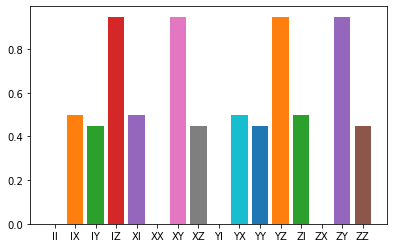

In [11]:
from qiskit.providers.aer.noise import pauli_error
from random import random

errorgen = 4
errorops = choices(pauli_basis(2, pauli_list = True), k=errorgen)
errorprobs = [random()*.1/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)

In [12]:
depths = [0,2,4,8,16,32]
results = []
samples = 32
for d in depths:
    result = 0
    for t in range(samples):
        circ, metadata = instance(Pauli("XZ"), Pauli("XZ"),d,transpiled=False)
        counts = sim.run(circ, shots = 1000, noise_model = noise_model).result().get_counts()
        result += get_expectation(Pauli("XZ"), counts = counts, rostring = metadata['rostring'])
        print(d,t, end='\r')
    results.append(result/samples)

In [13]:
from scipy.optimize import curve_fit
expfit = lambda x,a,b: a*np.exp(-b*x)
popt, pcov = curve_fit(expfit, depths, results, p0=[.9,.01])
print(np.exp(-popt[1]), real_errors[Pauli("XZ")])

0.9552074904471682 (0.9550406000025062+0j)


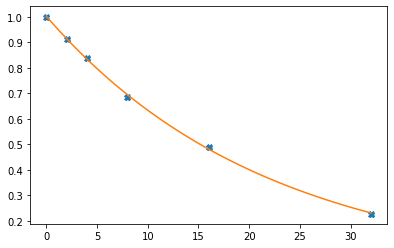

In [14]:
xrange = np.linspace(0,np.max(depths),100)
plt.plot(depths,results, "X")
plt.plot(xrange,[expfit(x,*popt) for x in xrange])

In [15]:
from numpy import single


def weight(pauli):
    return len([p for p in pauli if not p==Pauli("I")])
    
single_measurements = [(p1,p2) for (p1,p2) in pairs if p1 != p2 and weight(p1) == 1]
single_measurements += list(set([frozenset([p1,p2]) for p1,p2 in pairs if p1 != p2 and weight(p1) == 2 and weight(p2) == 2]))
single_measurements = [list(s) for s in single_measurements]

In [16]:
circuits = []
metadatas = []
depths = [0,2,4,8,16,32]
samples = [100]+[32]*5
single_samples = 100
total = len(bases)*sum(samples)+len(single_measurements)*single_samples

j=0
for basis, (d,s) in product(bases, zip(depths,samples)):

    for i in range(s):
        circ, data = instance(
            basis, 
            basis, 
            d, 
            )

        j+=1
        print(j,"/",total, end='\r')
        circuits.append(circ)
        metadatas.append(dict(**data, type = "double"))

for (pauli, pair), s in product(single_measurements, range(single_samples)):

    circ, data = instance(
        pair,
        pauli,
        1
    )
    j+=1
    print(j,"/",total, end='\r')
    circuits.append(circ)
    metadatas.append({"type":"single", **data})

In [17]:
results = sim.run(circuits, shots=250, noise_model = noise_model).result().get_counts()

In [18]:
def simultaneous_measurements(pauli):
    label = pauli.to_label()
    identity = "I"*n
    combos = zip(identity,label)
    sim_meas = []
    for pauli_string in product(*combos):
        sim_meas.append(Pauli("".join(pauli_string)))
    sim_meas.pop(0)
    return sim_meas

In [19]:
#Sort into single and double measurements
results_dict = [{**metadata, "counts":count} for metadata,count in zip(metadatas,results)]
singles = []
doubles = []
for datum in results_dict:
    type = datum["type"]
    datum.pop("type")
    if type == "single":
        singles.append(datum)
    elif type == "double":
        doubles.append(datum)

#reorder by measurement basis
basis_dict = {}
for datum in doubles:
    basis = datum['prep_basis']
    depth = datum['depth']
    for pauli in simultaneous_measurements(basis):
        expectation = get_expectation(pauli, **datum)
        if not pauli in basis_dict:
            basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
        basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
        basis_dict[pauli]["total"][depths.index(depth)] += 1

for key in basis_dict.keys():
    for i,d in enumerate(depths):
        basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
    popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
    basis_dict[key]["fidelity"] = expfit(1,1,popt[1])

    if key != commute_layer(key, two_qubit_gates):
        basis_dict[key]["type"] = "pair"
    else:
        basis_dict[key]["type"] = "single"

singles_dict = {}

for datum in singles:
    counts = datum['counts']
    prep_basis = datum['prep_basis']
    meas_basis = datum['meas_basis']

    if meas_basis not in singles_dict:
        singles_dict[meas_basis] = 0

    expectation = get_expectation(meas_basis, **datum)
    fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas_basis]["expectation"][0]])
    singles_dict[meas_basis] += fidelity/single_samples

for key in singles_dict.keys():
    basis_dict[key]['fidelity'] = singles_dict[key]
    basis_dict[key]['type'] = "single"

In [20]:
def graph(*paulis):
    colcy = cycle("rgbcmk")
    for p in paulis:
        c = next(colcy)
        data = basis_dict[p]['expectation']
        popt, pcov = curve_fit(expfit, depths, data, p0=[.9,.01])
        xrange = np.linspace(0,np.max(depths))
        plt.plot(depths, data, c+"X")
        plt.plot(xrange, [expfit(x, *popt) for x in xrange], c)

def display(*paulis):
    ax = np.arange(len(paulis))
    fidelities = []
    fidelities_calculated = []
    for p in paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = commute_layer(p, two_qubit_gates)
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='b')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='r')
    plt.xticks(ax, paulis)

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


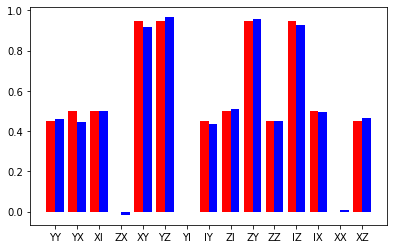

In [21]:
display(*model_terms)

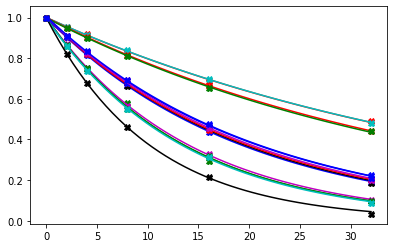

In [22]:
graph(*model_terms)

In [23]:
F1 = []
F2 = []
fidelities = []
for key in model_terms:
    F1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    if basis_dict[key]["type"] == "pair":
        pair = commute_layer(key, two_qubit_gates)
        F2.append(pair)
    else:
        F2.append(Pauli("I"*n))

In [24]:
sprod = lambda a,b: int(a.anticommutes(b))
M1 = [[sprod(a,b) for a in model_terms] for b in F1]
M2 = [[sprod(a,b) for a in model_terms] for b in F2]

In [25]:
np.linalg.matrix_rank(np.add(M1,M2)) == len(model_terms)

True

In [26]:
import scipy as sc
coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -.5*np.log(fidelities))

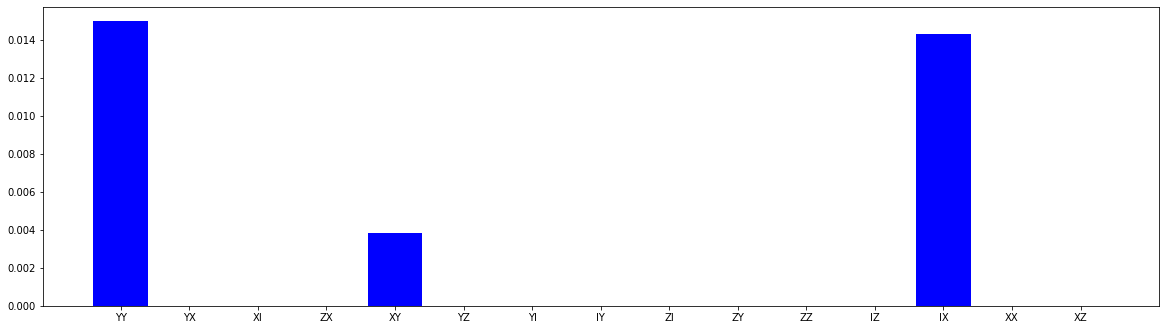

In [27]:
plt.rcParams["figure.figsize"] = (20,5.5)
for coeff,term in zip(coeffs, model_terms):
        plt.bar(term.to_label(), coeff, color='b')